In [8]:
pip install conllu

In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [10]:
pip install gensim --upgrade

In [11]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import nltk
from conllu import parse
from gensim.models import Word2Vec
from collections import Counter
from collections import defaultdict
from sklearn.preprocessing import LabelBinarizer
from torch.utils.data import DataLoader


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cd drive/MyDrive

/content/drive/MyDrive


In [14]:
ls


 ATnT/  'Colab Notebooks'/   my_model.pt   ud-treebanks-v2.13/


In [15]:


# Define paths to your CoNLL-U files
train_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-train.conllu"
test_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-test.conllu"
dev_path = "/content/drive/MyDrive/ud-treebanks-v2.13/UD_English-Atis/en_atis-ud-dev.conllu"


def load_conllu(file_path, p, s):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
    sentences = []
    pos_tags = []
    for sentence in parse(data):
        words = [token["form"].lower() for token in sentence]
        tags = [token["upos"] for token in sentence]

        # Add <START> and <POS> tags
        for i in range(0,p):

          words.insert(0,'<START>')
          words.append('<END>')

        for j in range(0,s):

          tags.insert(0,'<POS>')
          tags.append('<POS>')

        sentences.append(words)
        pos_tags.append(tags)
    #print(sentences[0], pos_tags[0])
    return sentences, pos_tags
# Load and preprocess data
p=3
s=3
train_sentences, train_pos_tags = load_conllu(train_path,p,s)
#print(len(train_sentences[0]))
# print(train_pos_tags)
dev_sentences,dev_pos_tags=load_conllu(dev_path,p,s)
test_sentences, test_pos_tags = load_conllu(test_path,p,s)


# # Build vocabulary
word_counts = Counter(word for sentence in train_sentences for word in sentence)
word_vocab = ["<UNK>"] + [word for word, count in word_counts.items() if count > 1]
#print(len(train_sentences[0]))
# print(wordcounts)
# print(word_vocab)_
for i, sentence in enumerate(train_sentences):
    train_sentences[i] = ['<UNK>' if word_counts[word] == 1 else word for word in sentence]
#print(train_sentences)


def replace_oov_with_unk(sentences, vocab):
    # Replace out-of-vocabulary words with <UNK> tag
    for i, sentence in enumerate(sentences):
        sentences[i] = ['<UNK>' if word not in vocab else word for word in sentence]
    return sentences

# Preprocess dev_sentences and test_sentences
dev_sentences = replace_oov_with_unk(dev_sentences, word_vocab)
test_sentences = replace_oov_with_unk(test_sentences, word_vocab)
# print(dev_sentences[0])
# print(test_sentences[0])

X_train = []
y_train = []

# Iterate through each sentence in train_sentences
for id,sentence in enumerate(train_sentences):
    # Iterate through the words in the sentence
    for i in range(len(sentence)):
        # Extract window of size 7 centered around the 3rd index word
        if i >= 3 and i < len(sentence) - 4:   #p-3 s+1 -4
            window = sentence[i - 3:i + 4]  # Extract window of size 7
            target_pos_tag = train_pos_tags[id][i]  # Get the POS tag of the word at the 3rd index
            X_train.append(window)
            y_train.append(target_pos_tag)

# Make a list of tuples containing (X, y) pairs
data = list(zip(X_train, y_train))
# print(len(X_train[0]))
# print(X_train[0])
# print(y_train[0])



X_dev = []
y_dev = []

# Iterate through each sentence in dev_sentences
for id,sentence in enumerate(dev_sentences):
    # Iterate through the words in the sentence
    for i in range(len(sentence)):
        # Extract window of size 7 centered around the 3rd index word
        if i >= 3 and i < len(sentence) - 4:   #p-3 s+1 -4
            window = sentence[i - 3:i + 4]  # Extract window of size 7
            target_pos_tag = dev_pos_tags[id][i]  # Get the POS tag of the word at the 3rd index
            X_dev.append(window)
            y_dev.append(target_pos_tag)

# Make a list of tuples containing (X, y) pairs
data = list(zip(X_dev, y_dev))
# print(len(X_dev[0]))
# print(X_dev[0])
# print(y_dev[0])

X_test = []
y_test = []

for id,sentence in enumerate(test_sentences):
    for i in range(len(sentence)):
        if i >= 3 and i < len(sentence) - 4:   #p-3 s+1 -4
            window = sentence[i - 3:i + 4]  # Extract window of size 7
            target_pos_tag = test_pos_tags[id][i]  # Get the POS tag of the word at the 3rd index
            X_test.append(window)
            y_test.append(target_pos_tag)

data = list(zip(X_test, y_test))
# print(len(X_test[0]))
# print(X_test[0])
# print(y_test[0])


# Train Word2Vec model
word2vec_model = Word2Vec(sentences=train_sentences, vector_size=100, window=5, min_count=1, workers=4)


word_embeddings_train= []
for sentence in X_train:
    sentence_embeddings = [word2vec_model.wv[word] if word in word2vec_model.wv else [0] * 100 for word in sentence]
    word_embeddings_train.append(sentence_embeddings)

print(len(word_embeddings_train[0]))
# print(word_embeddings_train[0])


word_embeddings_dev= []
for sentence in X_dev:
    sentence_embeddings = [word2vec_model.wv[word] if word in word2vec_model.wv else [0] * 100 for word in sentence]
    word_embeddings_dev.append(sentence_embeddings)

print(len(word_embeddings_dev[0]))
# print(word_embeddings_dev[0])

word_embeddings_test= []
for sentence in X_test:
    sentence_embeddings = [word2vec_model.wv[word] if word in word2vec_model.wv else [0] * 100 for word in sentence]
    word_embeddings_test.append(sentence_embeddings)

print(len(word_embeddings_test[0]))
# print(word_embeddings_test[0])

pos_vocab = defaultdict(lambda: len(pos_vocab))
for tags in train_pos_tags:
    for tag in tags:
        pos_vocab[tag]

print(pos_vocab)

reverse_pos_vocab = {}

for key, value in pos_vocab.items():
    reverse_pos_vocab[value] = key

print(reverse_pos_vocab)

# Convert pos_vocab to lists of POS tags and their corresponding indices
pos_tags, pos_indices = zip(*pos_vocab.items())

# Create an instance of LabelBinarizer
label_binarizer = LabelBinarizer()

# Fit the LabelBinarizer to the POS tags
label_binarizer.fit(pos_tags)

# Transform y using the fitted LabelBinarizer to obtain one-hot encodings
y_one_hot_train = label_binarizer.transform(y_train)
y_one_hot_dev = label_binarizer.transform(y_dev)
y_one_hot_test = label_binarizer.transform(y_test)

# print(y_one_hot_train)
# print(y_one_hot_dev)
# print(y_one_hot_test)





7
7
7
defaultdict(<function <lambda> at 0x7a788fb86560>, {'<POS>': 0, 'PRON': 1, 'AUX': 2, 'DET': 3, 'NOUN': 4, 'ADP': 5, 'PROPN': 6, 'VERB': 7, 'NUM': 8, 'ADJ': 9, 'CCONJ': 10, 'ADV': 11, 'PART': 12, 'INTJ': 13})
{0: '<POS>', 1: 'PRON', 2: 'AUX', 3: 'DET', 4: 'NOUN', 5: 'ADP', 6: 'PROPN', 7: 'VERB', 8: 'NUM', 9: 'ADJ', 10: 'CCONJ', 11: 'ADV', 12: 'PART', 13: 'INTJ'}


In [16]:
import torch
from torch.utils.data import Dataset
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.nn.utils.rnn import pad_sequence

START_TOKEN = "<START>"
END_TOKEN = "<END>"
UNKNOWN_TOKEN="<UNK>"
PAD_TOKEN = "<pad>"

class EntityDataset(Dataset):
    def __init__(self, data: list[tuple[list[str], list[int]]], vocabulary: Vocab|None = None):
        """Initialize the dataset. Setup Code goes here"""
        self.sentences = [i[0] for i in data]  # list of sentences
        self.labels = [i[1] for i in data]
        if vocabulary is None:
            self.vocabulary = build_vocab_from_iterator(self.sentences, specials=[START_TOKEN, END_TOKEN, UNKNOWN_TOKEN, PAD_TOKEN])  # use min_freq for handling unknown words better
        else:
            self.vocabulary = vocabulary

    def __len__(self) -> int:
        """Returns number of datapoints."""
        return len(self.sentences)

    def __getitem__(self, index: int) -> tuple[torch.Tensor, torch.Tensor]:
        """Get the datapoint at index."""
        return torch.tensor(self.sentences[index]), torch.tensor(self.labels[index]).float()

    def collate(self, batch: list[tuple[torch.Tensor, torch.Tensor]]) -> tuple[torch.Tensor, torch.Tensor]:
        """Given a list of datapoints, batch them together"""
        sentences = [i[0] for i in batch]
        labels = [i[1] for i in batch]
        padded_sentences = pad_sequence(sentences, batch_first=True, padding_value=self.vocabulary[PAD_TOKEN])  # pad sentences with pad token id
        padded_labels = pad_sequence(sentences, batch_first=True, padding_value=torch.tensor(0))  # pad labels with 0 because pad token cannot be entities

        return padded_sentences, padded_labels

print(len(word_embeddings_train[0]))
print(len(y_one_hot_train[0]))
word_embeddings_and_y_train = [(np.array(word_embedding).reshape(1,-1).tolist()[0], y_one_hot_train[i]) for i, word_embedding in enumerate(word_embeddings_train)]
print(type(word_embeddings_and_y_train))
entity_dataset_train = EntityDataset(word_embeddings_and_y_train,word_vocab)
print(len(entity_dataset_train[0][0]))

print(len(word_embeddings_dev[0]))
print(len(y_one_hot_dev[0]))

word_embeddings_and_y_dev = [(np.array(word_embedding).reshape(1,-1).tolist()[0], y_one_hot_dev[i]) for i, word_embedding in enumerate(word_embeddings_dev)]
print(type(word_embeddings_and_y_dev))
entity_dataset_dev = EntityDataset(word_embeddings_and_y_dev,word_vocab)
print(len(entity_dataset_dev[0][0]))

print(len(word_embeddings_test[0]))
print(len(y_one_hot_test[0]))

word_embeddings_and_y_test = [(np.array(word_embedding).reshape(1,-1).tolist()[0], y_one_hot_test[i]) for i, word_embedding in enumerate(word_embeddings_test)]
print(type(word_embeddings_and_y_test))
entity_dataset_test = EntityDataset(word_embeddings_and_y_test,word_vocab)
print(len(entity_dataset_test[0][0]))

7
14
<class 'list'>
700
7
14
<class 'list'>
700
7
14
<class 'list'>
700


In [17]:
import torch.nn as nn
import torch.nn.functional as F

# class FFNN(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size):
#         super(FFNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size)
#         self.fc2 = nn.Linear(hidden_size, output_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))  # Apply ReLU activation function to the first fully connected layer
#         x = self.fc2(x)  # Apply the second fully connected layer without activation function
#         return x

class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FFNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.fc4 = nn.Linear(hidden_size3, output_size)

    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))  # First hidden layer with Sigmoid activation
        x = torch.sigmoid(self.fc2(x))  # Second hidden layer with Sigmoid activation
        x = torch.sigmoid(self.fc3(x))  # Third hidden layer with Sigmoid activation
        x = self.fc4(x)                  # Output layer without activation
        return x

# class FFNN(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
#         super(FFNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.fc4 = nn.Linear(hidden_size3, output_size)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))  # First hidden layer with ReLU activation
#         x = F.relu(self.fc2(x))  # Second hidden layer with ReLU activation
#         x = F.relu(self.fc3(x))  # Third hidden layer with ReLU activation
#         x = self.fc4(x)          # Output layer without activation
#         return x


In [18]:
dataloader_train = DataLoader(entity_dataset_train, batch_size=200, shuffle=True)
# dataloader_train = DataLoader(entity_dataset_train, batch_size=100, shuffle=True)
# dataloader_train = DataLoader(entity_dataset_train, batch_size=50, shuffle=True)


In [ ]:
# class FFNN(nn.Module):
#     def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
#         super(FFNN, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.fc4 = nn.Linear(hidden_size3, output_size)

#     def forward(self, x):
#         x = torch.sigmoid(self.fc1(x))  # First hidden layer with Sigmoid activation
#         x = torch.sigmoid(self.fc2(x))  # Second hidden layer with Sigmoid activation
#         x = torch.sigmoid(self.fc3(x))  # Third hidden layer with Sigmoid activation
#         x = self.fc4(x)                  # Output layer without activation
#         return x

In [47]:

#model = FFNN(input_size=(p + s + 1) * 100, hidden_size=256, output_size=len(pos_vocab))
model = FFNN(input_size=(p+s+1)*100, hidden_size1=128, hidden_size2=64, hidden_size3=32, output_size=len(pos_vocab))

#model = FFNN(input_size=(p + s + 1) * 100, hidden_size=256, output_size=len(pos_vocab))
# print(output_size)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
patience=5
epoch_list = []
accuracy_list = []
best_accuracy = 0.0
no_improvement_count = 0
dev_predictions=[]
test_predictions=[]
real_dev_tags=[]
real_test_tags=[]
for epoch_num in range(50):
    model.train()
    for batch_num, (words, tags) in enumerate(dataloader_train):
        pred = model(torch.Tensor(words))
        loss = criterion(pred, tags)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch_num % 10 == 0:
        #    #print(f"{batch_num=}, {loss.item()=}")
    dev_predictions=[]
    real_dev_tags=[]

    model.eval()
    with torch.no_grad():
      total_correct = 0
      total_samples = 0
      for word, tag in entity_dataset_dev:
          pred = model(torch.Tensor(word))
          # print(pred)
          # print(pred.argmax().item())
          dev_predictions.append(reverse_pos_vocab[pred.argmax().item()])
          real_dev_tags.append(reverse_pos_vocab[tag.argmax().item()])
          total_samples += 1
          total_correct += (pred.argmax() == tag.argmax()).sum().item()
      accuracy = total_correct / total_samples
      print(f"epoch: {epoch_num} Validation accuracy: {accuracy}")
    # Append epoch and accuracy to lists
      epoch_list.append(epoch_num)
      accuracy_list.append(accuracy)
      if accuracy > best_accuracy:
          best_accuracy = accuracy
          no_improvement_count = 0
          # Save the model
      else:
          no_improvement_count += 1

      if no_improvement_count >= patience:
          print(f"No improvement in validation accuracy for {patience} epochs. Stopping training.")
          break


epoch: 0 Validation accuracy: 0.4105731225296443
epoch: 1 Validation accuracy: 0.5592885375494071
epoch: 2 Validation accuracy: 0.6393280632411067
epoch: 3 Validation accuracy: 0.70899209486166
epoch: 4 Validation accuracy: 0.7460474308300395
epoch: 5 Validation accuracy: 0.7776679841897233
epoch: 6 Validation accuracy: 0.8176877470355731
epoch: 7 Validation accuracy: 0.8325098814229249
epoch: 8 Validation accuracy: 0.8438735177865613
epoch: 9 Validation accuracy: 0.8598484848484849
epoch: 10 Validation accuracy: 0.8715415019762845
epoch: 11 Validation accuracy: 0.8913043478260869
epoch: 12 Validation accuracy: 0.8990447957839263
epoch: 13 Validation accuracy: 0.9005270092226614
epoch: 14 Validation accuracy: 0.9095849802371542
epoch: 15 Validation accuracy: 0.9117259552042161
epoch: 16 Validation accuracy: 0.9146903820816864
epoch: 17 Validation accuracy: 0.9229249011857708
epoch: 18 Validation accuracy: 0.9250658761528326
epoch: 19 Validation accuracy: 0.9267127799736495
epoch: 20 Va

In [48]:
test_predictions=[]
real_test_tags=[]
best_acc_test=0.0
patience=5
model.eval()
with torch.no_grad():
  total_correct = 0
  total_samples = 0
  for word, tag in entity_dataset_test:
      pred = model(torch.Tensor(word))
      # print(pred)
      # print(pred.argmax().item())
      test_predictions.append(reverse_pos_vocab[pred.argmax().item()])
      real_test_tags.append(reverse_pos_vocab[tag.argmax().item()])
      total_samples += 1
      total_correct += (pred.argmax() == tag.argmax()).sum().item()
      # test_predictions.clear()
      # real_test_tags.clear()
  accuracy = total_correct / total_samples
  print(f"Testing accuracy: {accuracy}")

  if accuracy > best_acc_test:
      best_acc_test = accuracy
      no_improvement_count = 0
      # Save the model
  else:
      no_improvement_count += 1

  if no_improvement_count >= patience:
      print(f"No improvement in Testing accuracy for {patience} epochs. Stopping training.")


Testing accuracy: 0.9310977644310978


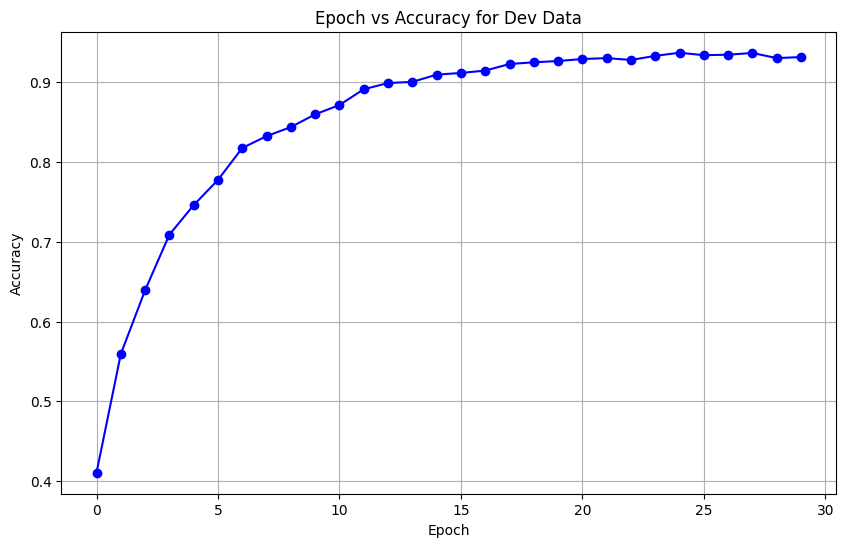

In [58]:
# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(epoch_list, accuracy_list, marker='o', color='b', linestyle='-')
plt.title('Epoch vs Accuracy for Dev Data')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

In [ ]:
torch.save(model, f"/content/my_model_hiddenlaye3_sigmoid.pt_{p}")

In [49]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:

    # Calculate metrics and confusion matrix for dev set
dev_accuracy = accuracy_score(real_dev_tags, dev_predictions)
dev_recall_micro = recall_score(real_dev_tags, dev_predictions, average='micro')
dev_recall_macro = recall_score(real_dev_tags, dev_predictions, average='macro')
dev_f1_micro = f1_score(real_dev_tags, dev_predictions, average='micro')
dev_f1_macro = f1_score(real_dev_tags, dev_predictions, average='macro')
dev_conf_matrix = confusion_matrix(real_dev_tags, dev_predictions)



In [51]:
# Calculate metrics and confusion matrix for test set
test_accuracy = accuracy_score(real_test_tags, test_predictions)
test_recall_micro = recall_score(real_test_tags, test_predictions, average='micro')
test_recall_macro = recall_score(real_test_tags, test_predictions, average='macro')
test_f1_micro = f1_score(real_test_tags, test_predictions, average='micro')
test_f1_macro = f1_score(real_test_tags, test_predictions, average='macro')
test_conf_matrix = confusion_matrix(real_test_tags, test_predictions)

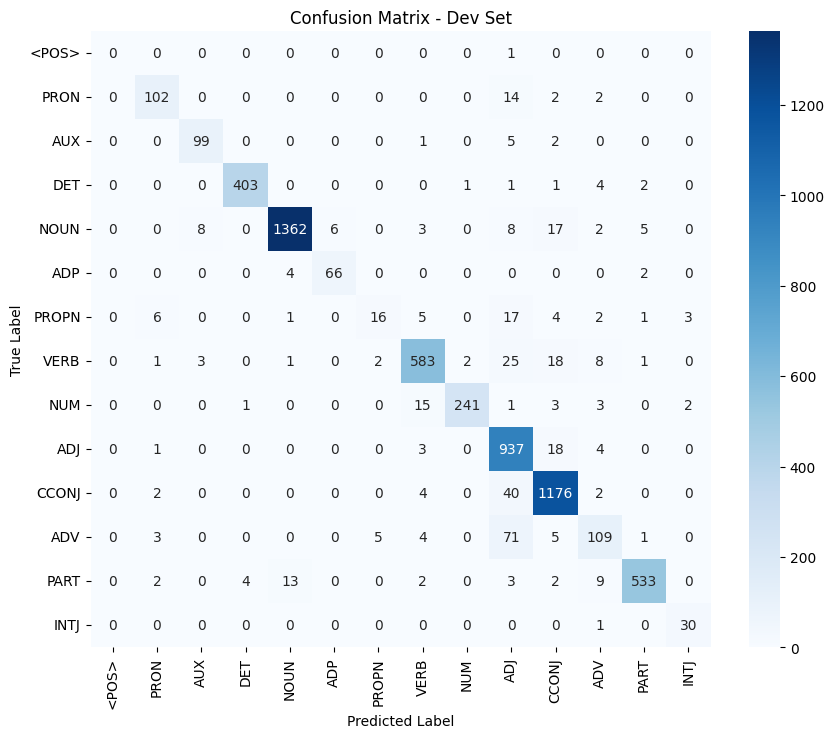

In [53]:
# Plot confusion matrix for dev set
plt.figure(figsize=(10, 8))
sns.heatmap(dev_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=pos_vocab, yticklabels=pos_vocab)
plt.title('Confusion Matrix - Dev Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



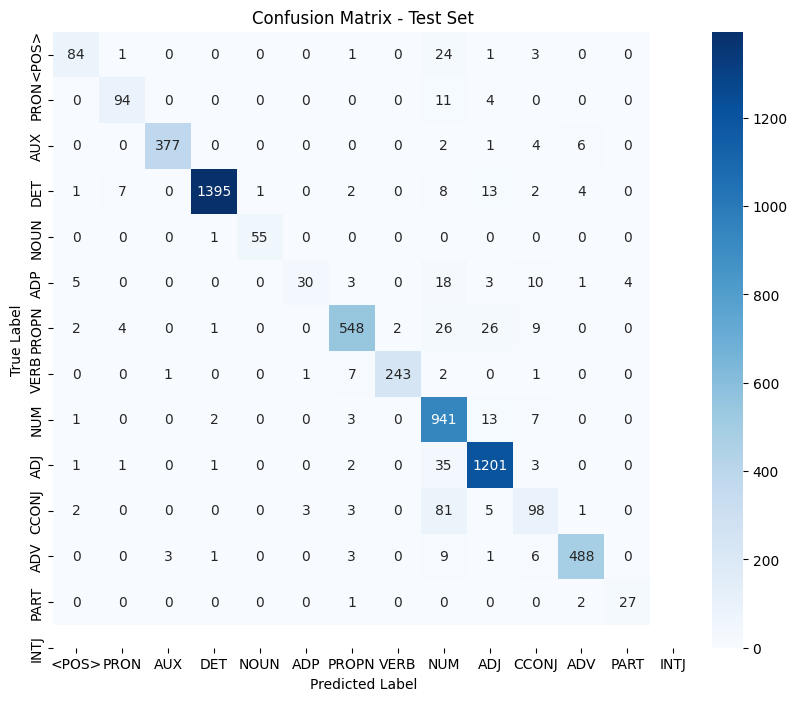

In [55]:

# Plot confusion matrix for test set
plt.figure(figsize=(10, 8))
sns.heatmap(test_conf_matrix, annot=True, cmap='Blues', fmt='g', xticklabels=pos_vocab, yticklabels=pos_vocab)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [56]:
from tabulate import tabulate

# Create a list of evaluation metrics
metrics_data = [
    ["Accuracy", dev_accuracy],
    ["Recall (micro)", dev_recall_micro],
    ["Recall (macro)", dev_recall_macro],
    ["F1 Score (micro)", dev_f1_micro],
    ["F1 Score (macro)", dev_f1_macro]
]

# Print the evaluation metrics in tabular format
print("Dev set evaluation:")
print(tabulate(metrics_data, headers=["Metric", "Value"], tablefmt="grid"))


Dev set evaluation:
+------------------+----------+
| Metric           |    Value |
+==================+==========+
| Accuracy         | 0.931653 |
+------------------+----------+
| Recall (micro)   | 0.931653 |
+------------------+----------+
| Recall (macro)   | 0.794853 |
+------------------+----------+
| F1 Score (micro) | 0.931653 |
+------------------+----------+
| F1 Score (macro) | 0.805477 |
+------------------+----------+


In [57]:


# Create a list of evaluation metrics for the test set
test_metrics_data = [
    ["Accuracy", test_accuracy],
    ["Recall (micro)", test_recall_micro],
    ["Recall (macro)", test_recall_macro],
    ["F1 Score (micro)", test_f1_micro],
    ["F1 Score (macro)", test_f1_macro]
]

# Print the evaluation metrics for the test set in tabular format
print("Test set evaluation:")
print(tabulate(test_metrics_data, headers=["Metric", "Value"], tablefmt="grid"))


Test set evaluation:
+------------------+----------+
| Metric           |    Value |
+==================+==========+
| Accuracy         | 0.931098 |
+------------------+----------+
| Recall (micro)   | 0.931098 |
+------------------+----------+
| Recall (macro)   | 0.851377 |
+------------------+----------+
| F1 Score (micro) | 0.931098 |
+------------------+----------+
| F1 Score (macro) | 0.872081 |
+------------------+----------+


In [ ]:
loaded_model = torch.load(f"/content/my_model.pt_{p}")

In [ ]:
word2vec_model.wv.save_word2vec_format('word2vec_embeddings.txt', binary=False)
